In [57]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import trange, tqdm
import joblib

from pcap_processor import calculate_features



In [58]:
# Check if CUDA (NVIDIA's GPU programming toolkit) is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
    print("Number of GPUs available:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. PyTorch cannot use the GPU.")

CUDA is available. PyTorch can use the GPU.
Number of GPUs available: 1
GPU Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [59]:
# Load the tensors from the .pt files
data_tensors = torch.load('data_tensors_5s_0.2s.pt')
target_tensors = torch.load('target_tensors_5s_0.2s.pt')

print("Data tensors and target tensors loaded successfully!")

# Example usage: Checking the shapes of the loaded tensors
print(f"Number of data samples: {len(data_tensors)}")
print(f"Shape of first data sample: {data_tensors[0].shape}")
print(f"Shape of target tensor: {target_tensors.shape}")

Data tensors and target tensors loaded successfully!
Number of data samples: 3000
Shape of first data sample: torch.Size([20, 22])
Shape of target tensor: torch.Size([3000])


In [60]:

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.rnn(x)
        out = self.fc(h_n[-1])
        return out


# Define custom dataset
class PacketCaptureDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]



In [61]:
# normalize the target tensors
target_mean = target_tensors.mean()
target_std = target_tensors.std()

# make a function to denormalize a prediction
def denormalize(tensor):
    return tensor * target_std + target_mean

target_tensors = (target_tensors - target_mean) / target_tensors.std()

train_data, test_data, train_targets, test_targets = train_test_split(
    data_tensors, target_tensors, test_size=0.2, random_state=42
)

# Create datasets and data loaders
train_dataset = PacketCaptureDataset(train_data, train_targets)
test_dataset = PacketCaptureDataset(test_data, test_targets)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [62]:
input_size = len(
    train_dataset[0][0][0]
)  # Assuming all packet captures have the same structure
hidden_size = 64
output_size = 1
model = RNNModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [63]:
# FILEPATH: /home/ziv/Desktop/coding/speedtest-research/cs293n/model/lstm.ipynb
# model.load_state_dict(torch.load('model_weights_10s_0.01s.pt'))

num_epochs = 5_000

model.train()
with tqdm(total=num_epochs) as pbar:
    prev_loss = float('inf')
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1
        average_loss = total_loss / num_batches
        pbar.set_description(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
        pbar.update(1)
        
        # Check for convergence
        # if abs(prev_loss - average_loss) < 1e-5:
        #     print("Model converged. Stopping iterations.")
        #     break
        
        prev_loss = average_loss



Epoch 105, Loss: 38.8632:   2%|▏         | 105/5000 [01:55<1:30:03,  1.10s/it]

Model converged. Stopping iterations.


In [64]:
# save the weights of the model to a file
torch.save(model.state_dict(), 'model_weights_5s_0.2s.pt')

In [65]:
total_absolute_error = 0
num_samples = len(test_targets)

for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    absolute_error = abs(predicted_value - actual_value)
    total_absolute_error += absolute_error

average_absolute_error = total_absolute_error / num_samples
print(f"Average Absolute Error: {average_absolute_error}")


Average Absolute Error: 0.2947074898557427


In [66]:
# get the average absolute error for the denormalized values
total_absolute_error = 0
num_samples = len(test_targets)

for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    absolute_error = abs(predicted_value - actual_value)
    total_absolute_error += absolute_error

average_absolute_error = total_absolute_error / num_samples
print(f"Average Absolute Error (Denormalized): {average_absolute_error}")


Average Absolute Error (Denormalized): 33.28517532348633


In [67]:
# get the median absolute error
absolute_errors = []
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    absolute_error = abs(predicted_value - actual_value)
    absolute_errors.append(absolute_error)

median_absolute_error = np.median(absolute_errors)
print(f"Median Absolute Error: {median_absolute_error}")

Median Absolute Error: 0.03941328823566437


In [68]:
# get the median absolute error for the denormalized values
absolute_errors = []
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    absolute_error = abs(predicted_value - actual_value)
    absolute_errors.append(absolute_error)

median_absolute_error = np.median(absolute_errors)
print(f"Median Absolute Error (Denormalized): {median_absolute_error}")


Median Absolute Error (Denormalized): 4.451458930969238


In [69]:
# get the mean square error
total_square_error = 0
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    square_error = (predicted_value - actual_value) ** 2
    total_square_error += square_error

mean_square_error = total_square_error / num_samples
print(f"Mean Square Error: {mean_square_error}")


Mean Square Error: 0.8301902204725373


In [70]:
# get the mean square error for the denormalized values
total_square_error = 0
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    square_error = (predicted_value - actual_value) ** 2
    total_square_error += square_error

mean_square_error = total_square_error / num_samples
print(f"Mean Square Error (Denormalized): {mean_square_error}")


Mean Square Error (Denormalized): 10590.025390625


In [71]:
# print each actual vs prediction value
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    print(f"Actual: {actual_value}, Predicted: {predicted_value}")

Actual: -0.2137780338525772, Predicted: -0.2148517668247223
Actual: -0.2220989316701889, Predicted: -0.16866865754127502
Actual: -0.14433108270168304, Predicted: -0.20230290293693542
Actual: 5.9103007316589355, Predicted: 0.08017522096633911
Actual: 1.1538177728652954, Predicted: 0.102243572473526
Actual: -0.2590367794036865, Predicted: -0.2621590793132782
Actual: -0.2450065165758133, Predicted: -0.22550168633460999
Actual: -0.19820664823055267, Predicted: -0.15371206402778625
Actual: 0.005389319267123938, Predicted: 0.467343807220459
Actual: 2.4904119968414307, Predicted: 2.7830703258514404
Actual: -0.22122852504253387, Predicted: -0.22698137164115906
Actual: -0.2597081661224365, Predicted: -0.25243034958839417
Actual: -0.2326887845993042, Predicted: -0.19150343537330627
Actual: -0.21501336991786957, Predicted: -0.22782635688781738
Actual: -0.19711652398109436, Predicted: -0.19691190123558044
Actual: -0.23424959182739258, Predicted: -0.23872557282447815
Actual: -0.25766223669052124, P

In [72]:
# print each actual vs prediction value for denormalized values
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    print(f"Actual: {actual_value}, Predicted: {predicted_value}")


Actual: 5.373250961303711, Predicted: 5.251981735229492
Actual: 4.433464050292969, Predicted: 10.46804428100586
Actual: 13.216806411743164, Predicted: 6.669288635253906
Actual: 697.0457153320312, Predicted: 38.573246002197266
Actual: 159.83377075195312, Predicted: 41.065711975097656
Actual: 0.26158905029296875, Predicted: -0.09105300903320312
Actual: 1.8462104797363281, Predicted: 4.04914665222168
Actual: 7.131933212280273, Predicted: 12.157289505004883
Actual: 30.126693725585938, Predicted: 82.30126953125
Actual: 310.7928771972656, Predicted: 343.84661865234375
Actual: 4.531770706176758, Predicted: 3.8820266723632812
Actual: 0.185760498046875, Predicted: 1.0077400207519531
Actual: 3.2374134063720703, Predicted: 7.889013290405273
Actual: 5.233728408813477, Predicted: 3.786590576171875
Actual: 7.255054473876953, Predicted: 7.278165817260742
Actual: 3.0611305236816406, Predicted: 2.5555992126464844
Actual: 0.41683387756347656, Predicted: 0.9128265380859375
Actual: 0.6501827239990234, Pre

In [73]:
# calculate the average percentage error of the model
total_percentage_error = 0
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    total_percentage_error += percentage_error

average_percentage_error = (total_percentage_error / num_samples) * 100
print(f"Average Percentage Error: {average_percentage_error}%")
# print the standard deviation of the percentage errors
percentage_errors = []
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors: {percentage_errors_std}")


# remove the max 2 percent of the errors and calculate the average percentage error
sorted_errors = sorted(absolute_errors)
num_samples_to_remove = int(num_samples * 0.02)
sorted_errors = sorted_errors[:-num_samples_to_remove]
average_percentage_error = (sum(sorted_errors) / len(sorted_errors)) / target_mean
print(f"Average Percentage Error (Without Top 2%): {average_percentage_error * 100}%")
# print the standard deviation of the percentage errors
percentage_errors = []
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors = percentage_errors[:-num_samples_to_remove]
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Without Top 2%): {percentage_errors_std}")


Average Percentage Error: 552.1976976006404%
Standard Deviation of Percentage Errors: 62.102908854092334
Average Percentage Error (Without Top 2%): 74.2029800415039%
Standard Deviation of Percentage Errors (Without Top 2%): 62.72906991701382


In [74]:
# calculate the average percentage error of the model for denormalized values
total_percentage_error = 0
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    total_percentage_error += percentage_error

average_percentage_error = (total_percentage_error / num_samples) * 100
print(f"Average Percentage Error (Denormalized): {average_percentage_error}%")

# print the standard deviation of the percentage errors for denormalized values
percentage_errors = []  
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Denormalized): {percentage_errors_std}")

# remove the max 2 percent of the errors and calculate the average percentage error for denormalized values
sorted_errors = sorted(absolute_errors)
num_samples_to_remove = int(num_samples * 0.02)
sorted_errors = sorted_errors[:-num_samples_to_remove]
average_percentage_error = (sum(sorted_errors) / len(sorted_errors)) / target_mean
print(f"Average Percentage Error (Without Top 2%, Denormalized): {average_percentage_error * 100}%")
# print the standard deviation of the percentage errors for denormalized values
percentage_errors = []
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors = percentage_errors[:-num_samples_to_remove]
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Without Top 2%, Denormalized): {percentage_errors_std}")



Average Percentage Error (Denormalized): 650.4979248046875%
Standard Deviation of Percentage Errors (Denormalized): 21.839311599731445
Average Percentage Error (Without Top 2%, Denormalized): 74.2029800415039%
Standard Deviation of Percentage Errors (Without Top 2%, Denormalized): 22.045997619628906


In [75]:
# calculate the median percentage error of the model
percentage_errors = []
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0)).item()
    actual_value = test_targets[i].item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)
    if percentage_error < 0:
        print(f"Predicted: {predicted_value}, Actual: {actual_value}, PE: {percentage_error}")


median_percentage_error = np.median(percentage_errors) * 100
print(f"Median Percentage Error: {median_percentage_error}%")


Median Percentage Error: 17.668752814598086%


In [76]:
# calculate the median percentage error of the model for denormalized values
percentage_errors = []
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)
    if percentage_error < 0:
        print(f"Predicted: {predicted_value}, Actual: {actual_value}, PE: {percentage_error}")

median_percentage_error = np.median(percentage_errors) * 100
print(f"Median Percentage Error (Denormalized): {median_percentage_error}%")

Median Percentage Error (Denormalized): 141.70936346054077%


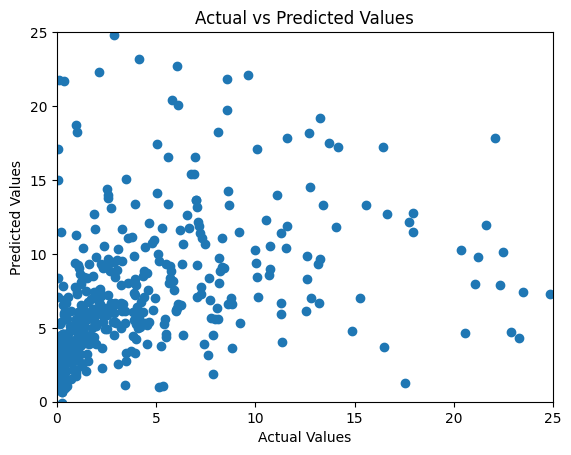

In [77]:
# plot the denormalized values for the actual and predicted values on testing set

import matplotlib.pyplot as plt

actual_values = []
predicted_values = []
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0)).item())
    actual_value = denormalize(test_targets[i].item())
    actual_values.append(actual_value)
    predicted_values.append(predicted_value)

plt.scatter(actual_values, predicted_values)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.xlim(0, 25)
plt.ylim(0, 25)
plt.show()

